In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
%matplotlib inline

In [3]:
int_airline_passengers = pd.read_csv('D:/Учеба/16. Временные ряды/1. Знакомство с временными рядами/international-airline-passengers.csv')
int_airline_passengers = int_airline_passengers.dropna()

In [22]:
int_airline_passengers

,Month,Count
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0


In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [10]:
series1 = int_airline_passengers['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


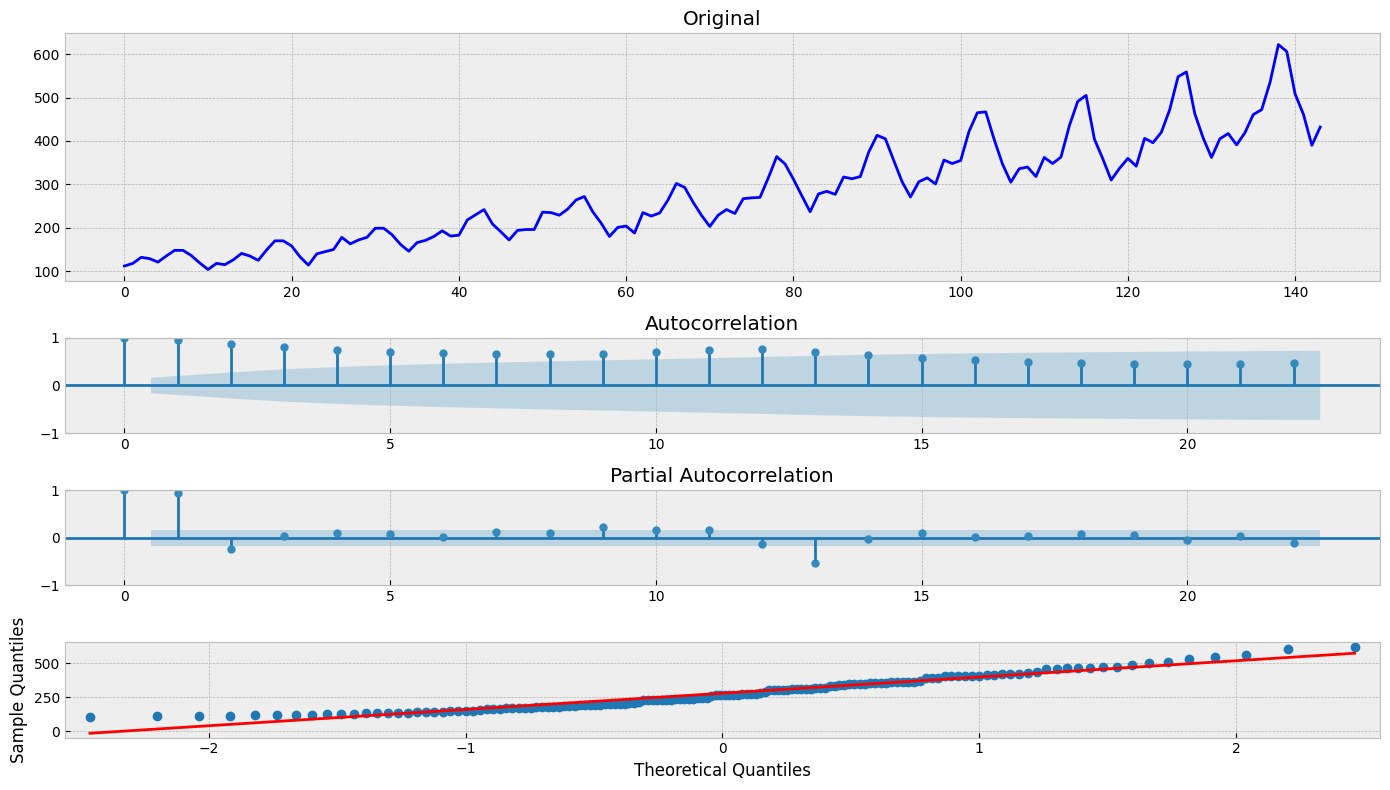

In [11]:
tsplot(series1)

In [12]:
#используем функцию Box-Cox, которая преобразует данные таким образом, чтобы они следовали нормальному распределению.
series1 = boxcox(series1, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


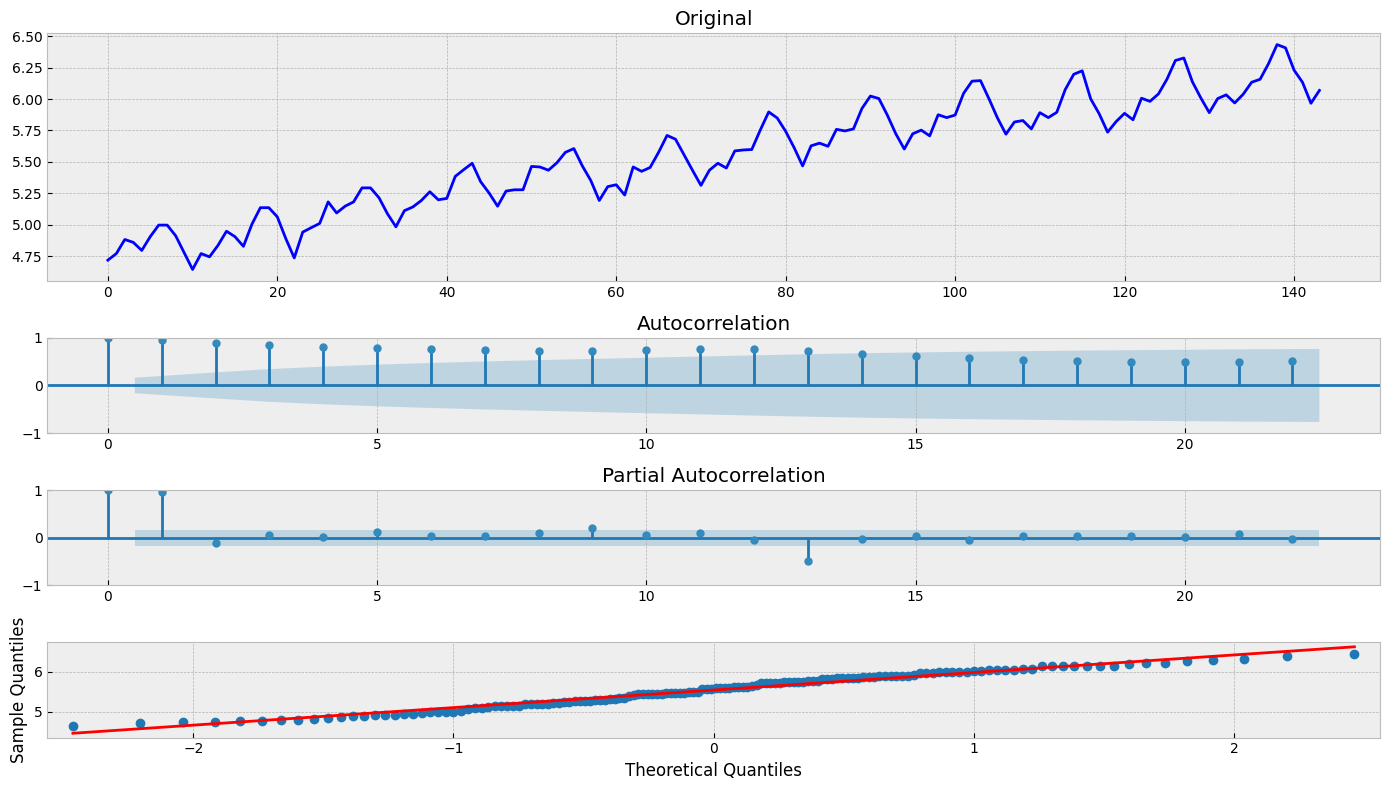

In [13]:
tsplot(series1)

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


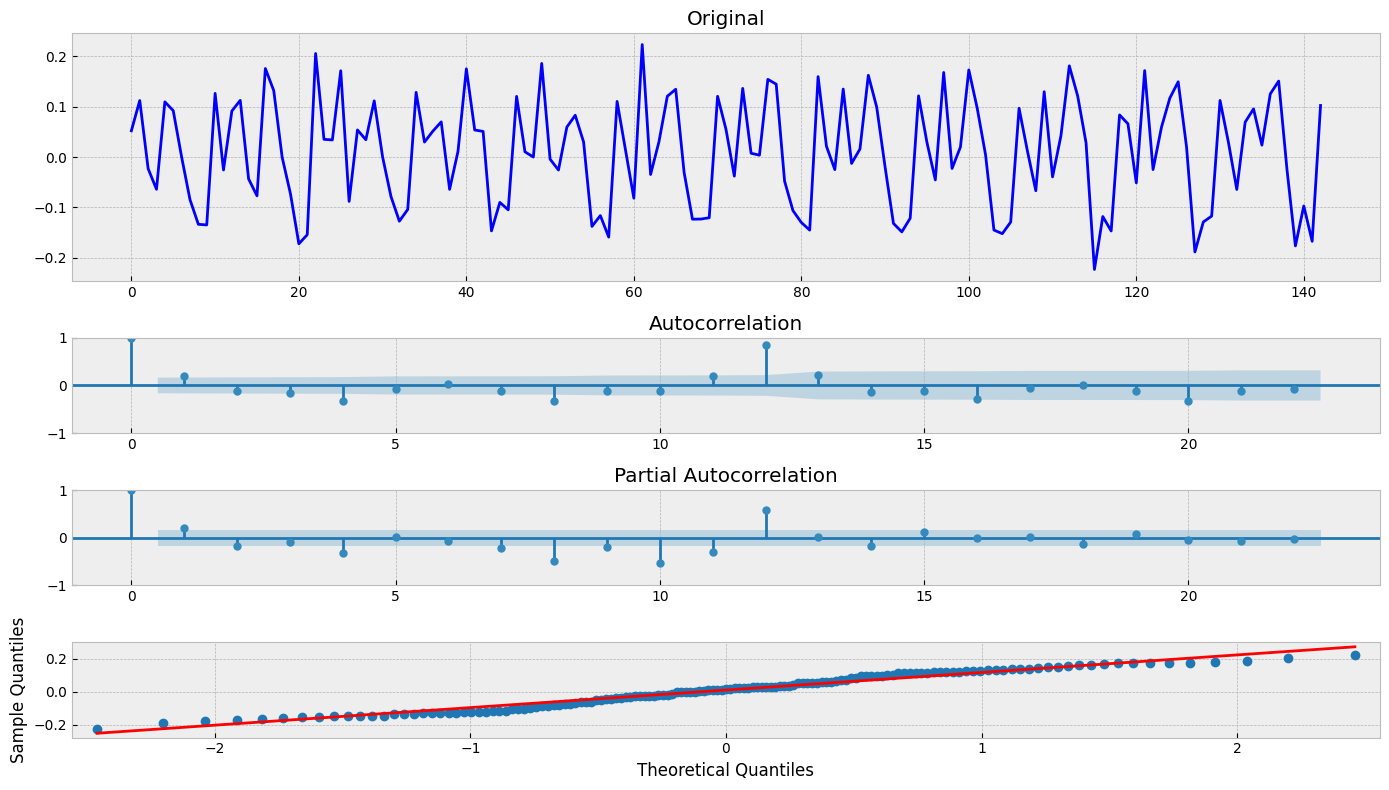

In [14]:
#Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда.
#По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.
series1 = np.diff(series1, 1)
tsplot(series1)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


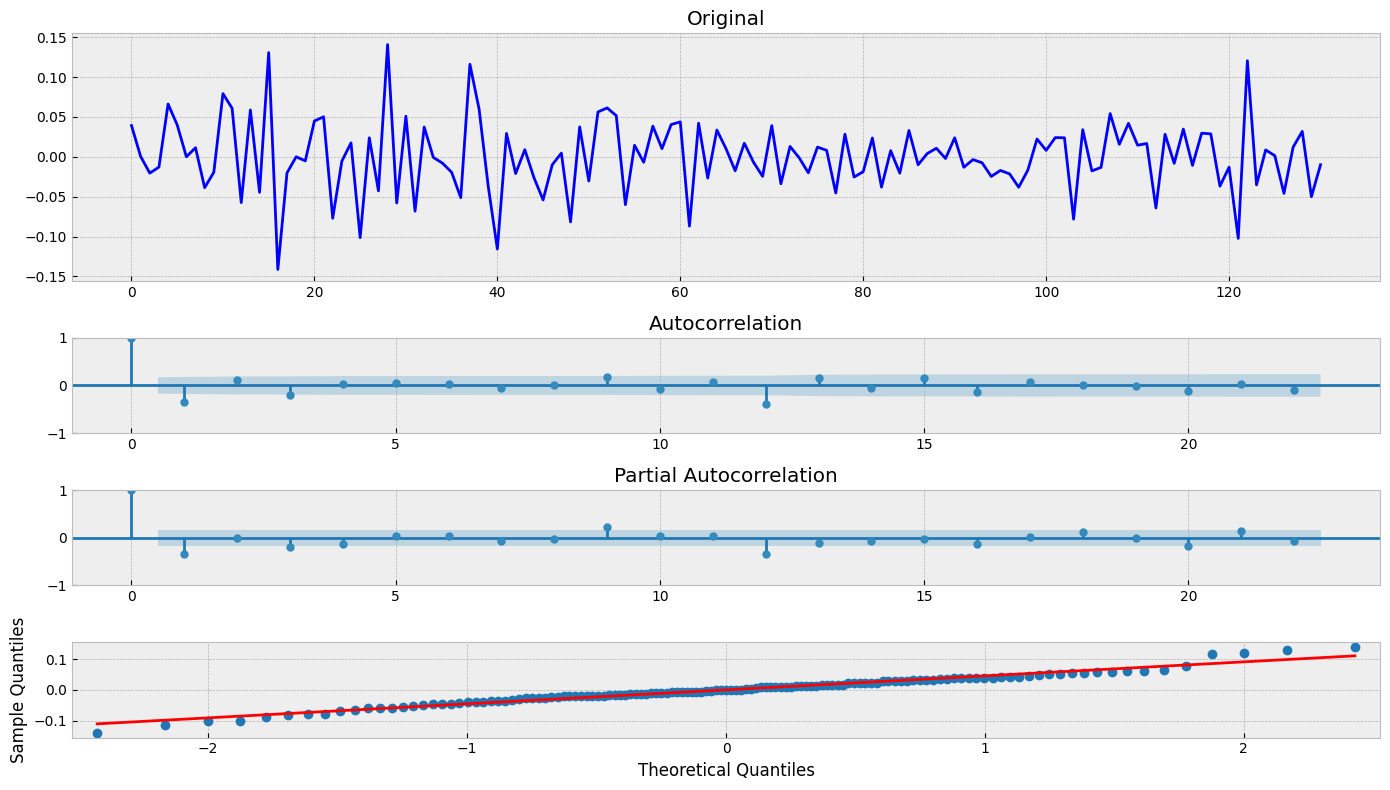

In [15]:
#Стало еще лучше, но по графику коррелограммы видно сильное влияние сезонности. Уберем ее
series1 = series1[12:] - series1[:-12]
tsplot(series1)

In [23]:
model_ma_stationary = ARIMA(series1, order=(0, 0, 1))
result_ma_stationary = model_ma_stationary.fit()
print("MA модель для стационарного ряда:\n", result_ma_stationary.summary())

MA модель для стационарного ряда:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 226.995
Date:                Sun, 02 Jun 2024   AIC                           -447.991
Time:                        08:39:40   BIC                           -439.365
Sample:                             0   HQIC                          -444.486
                                - 131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.108      0.914      -0.004       0.005
ma.L1         -0.3872      0.070     -5.529      0.000      -0.524      -0.250
sigma2         0.

In [24]:
print("AIC для стационарного ряда:", result_ma_stationary.aic)
print("BIC для стационарного ряда:", result_ma_stationary.bic)

AIC для стационарного ряда: -447.9907805194206
BIC для стационарного ряда: -439.3651885498171


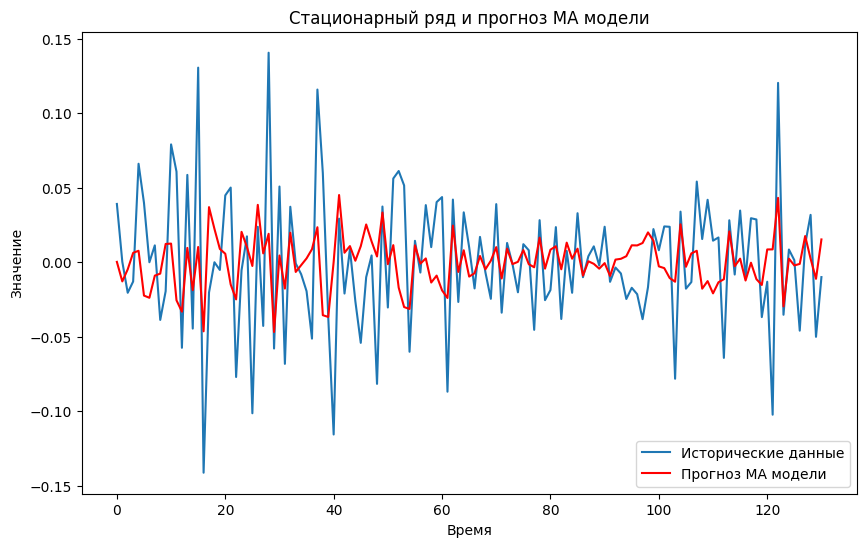

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(series1, label='Исторические данные')
plt.plot(result_ma_stationary.fittedvalues, color='red', label='Прогноз MA модели')
plt.title('Стационарный ряд и прогноз MA модели')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()